# **Instituto Tecnológico Vale**

## **Introdução a Visão Computacional**

### **Reconhecimento de imagem**

## **Exemplo prático**

### Transfer learning

In [1]:
# baixar e descompactar os dados do exemplo
# Será criado a pasta flowers_data no ambiente do colab

!wget -O flowers_photos.zip https://www.dropbox.com/s/59j0798c3h3oukq/flower-photos.zip?dl=0;

!unzip flowers_photos.zip;

!wget -O vgg_16_architecture.png https://www.dropbox.com/s/f1yz19pd96mx3ya/vgg_16_architecture.png?dl=0;

--2021-08-23 19:21:20--  https://www.dropbox.com/s/59j0798c3h3oukq/flower-photos.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/59j0798c3h3oukq/flower-photos.zip [following]
--2021-08-23 19:21:20--  https://www.dropbox.com/s/raw/59j0798c3h3oukq/flower-photos.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc773cc8074e48b644bbfccf4cc2.dl.dropboxusercontent.com/cd/0/inline/BUwUI9X_XEMXLcYtZLIPK-xAply8re2vsD5rS1FuAAF2zS-vkYo1N-wkEW1rkaw3oXsmu74TcreIn2HTx5-e2V8PdN-0R4Ph0kVhPoskxjgboMNELF9k2vLpVXFmcT36FPJePUKA_fJtjK75bckjiOw5/file# [following]
--2021-08-23 19:21:20--  https://uc773cc8074e48b644bbfccf4cc2.dl.dropboxusercontent.com/cd/0/inline/BUwUI9X_XEMXLcYtZLIPK-xAply8re2vsD5rS1FuAAF2zS-vkYo1N-wkEW1rkaw3oXs

### Tranfer Learning usando a arquitetura VGG16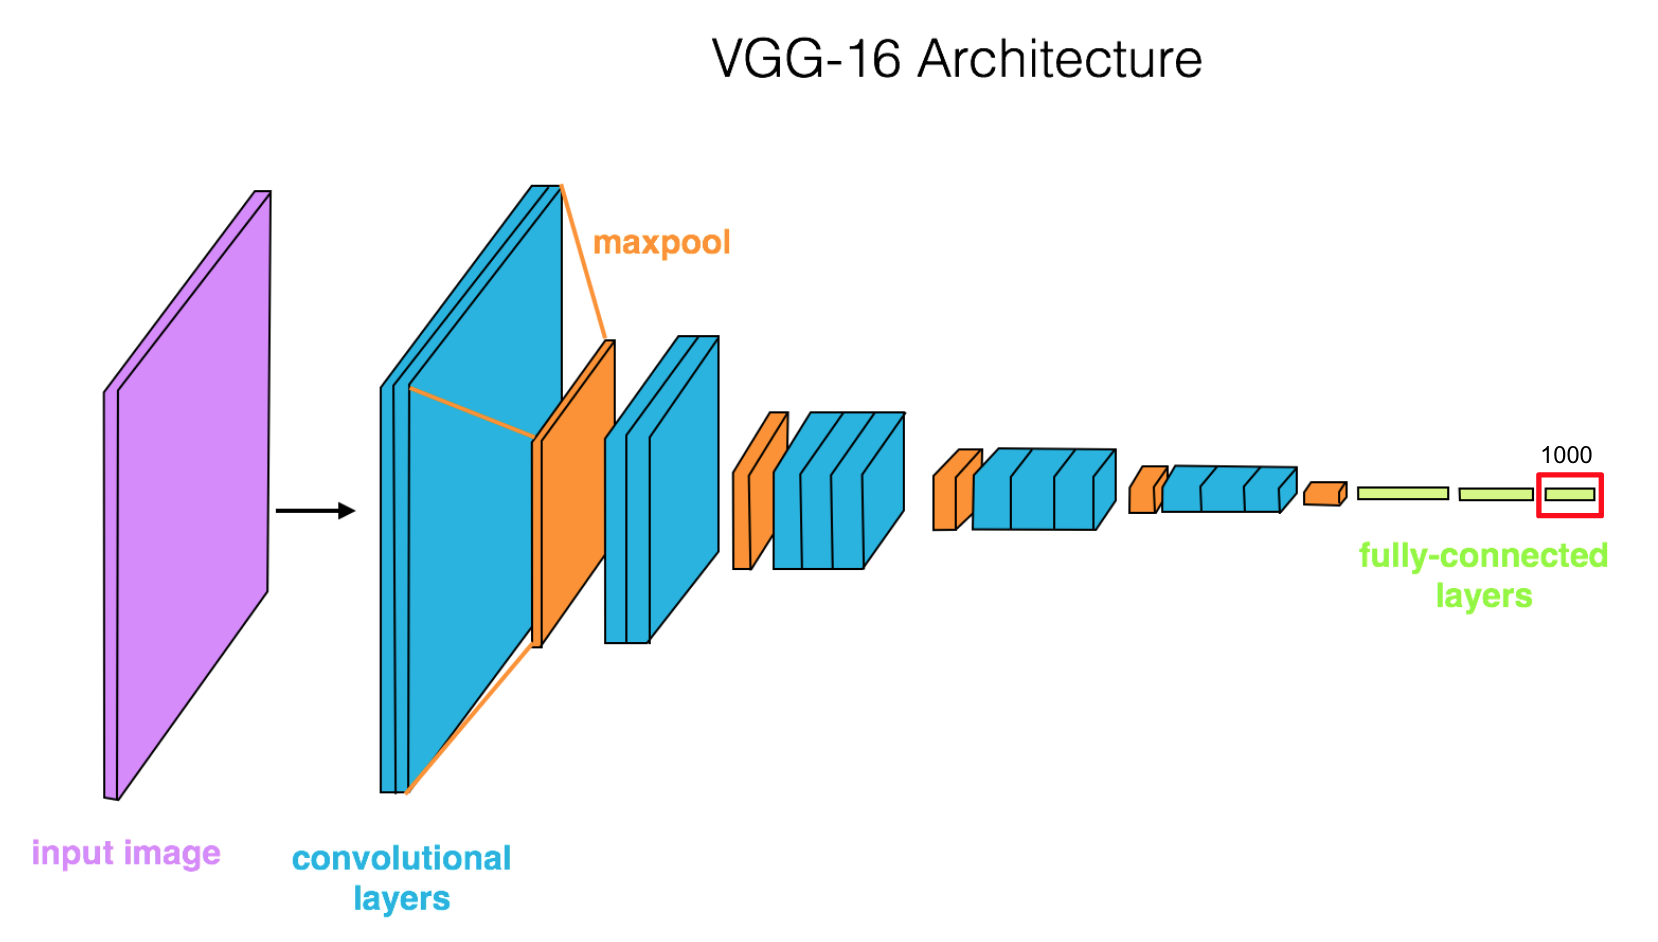

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully-connected layer with our own classifier. This way we can use VGGNet as a fixed feature extractor for our images then easily train a simple classifier on top of that.

- Use all but the last fully-connected layer as a fixed feature extractor.

- Define a new, final classification layer and apply it to a task of our choice!

In [83]:
# imports 

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## **Load and Transform our Data**

In [6]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

In [7]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [8]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

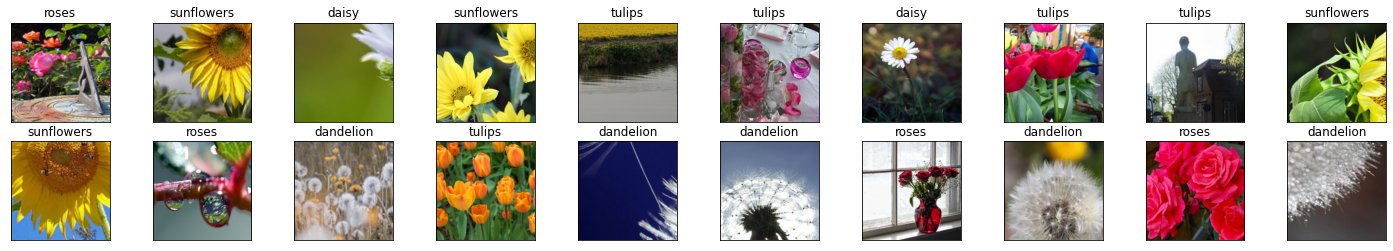

In [9]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## **Define the Model**

To define a model for training we'll follow these steps:

1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

In [10]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [12]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers.

  - This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

In [18]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

5


In [19]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Specify Loss Function and Optimizer

In [21]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

### Training

In [22]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, Batch 20 loss: 1.5790262699127198
Epoch 1, Batch 40 loss: 1.3715576529502869
Epoch 1, Batch 60 loss: 1.2313798487186431
Epoch 1, Batch 80 loss: 1.1217241466045380
Epoch 1, Batch 100 loss: 1.0312708020210266
Epoch 1, Batch 120 loss: 0.9947172701358795
Epoch 1, Batch 140 loss: 0.9288705408573150
Epoch 2, Batch 20 loss: 0.9030409455299377
Epoch 2, Batch 40 loss: 0.8696494430303574
Epoch 2, Batch 60 loss: 0.7823928773403168
Epoch 2, Batch 80 loss: 0.8009343236684799
Epoch 2, Batch 100 loss: 0.8090425461530686
Epoch 2, Batch 120 loss: 0.7842949002981185
Epoch 2, Batch 140 loss: 0.8145258843898773
Epoch 3, Batch 20 loss: 0.7530853673815727
Epoch 3, Batch 40 loss: 0.6998229250311852
Epoch 3, Batch 60 loss: 0.7642480596899986
Epoch 3, Batch 80 loss: 0.6817619964480400
Epoch 3, Batch 100 loss: 0.7414491236209869
Epoch 3, Batch 120 loss: 0.7318457439541817
Epoch 3, Batch 140 loss: 0.6720091447234153
Epoch 4, Batch 20 loss: 0.6212472602725029
Epoch 4, Batch 40 loss: 0.6869351506233216
Ep

### Testing

In [23]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.568483

Test Accuracy of daisy: 73% (68/92)
Test Accuracy of dandelion: 93% (123/132)
Test Accuracy of roses: 64% (59/91)
Test Accuracy of sunflowers: 83% (84/101)
Test Accuracy of tulips: 79% (98/124)

Test Accuracy (Overall): 80% (432/540)


### Visualize Sample Test Results

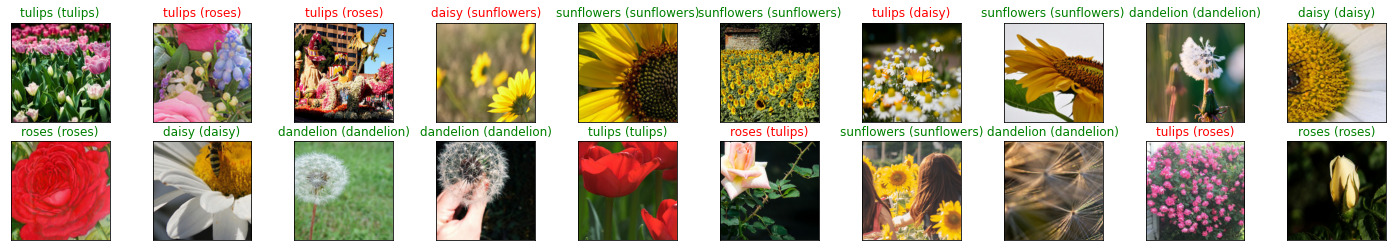

In [25]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### E para carrear uma nova imagem?

Use o seu modelo treinado, passe a imagem pela rede realizndo os mesmos procedimentos anteriores e veja a resposta.

#### Salvando a rede

A função a seguir salva os pesos da rede de acordo a sua estrutura 

In [27]:
torch.save(vgg16.state_dict(), 'vgg16_model.pt')

#### E para usar o modelo salvo?

Carregue a estrutura da sua rede, após isso carregue os pesos salvos.

In [29]:
# Carregando a estrutura
model = models.vgg16()

# Ajustando a última camada para o nosso problema
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

# Carregando de fato os pesos salvos
model.load_state_dict(torch.load('vgg16_model.pt'))

model = model.cuda()

model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Baixando uma imagem de tulipa

In [30]:
!wget -O tulipas.jpg https://www.dropbox.com/s/u9798t3vsn4lkfn/tulipas.jpg?dl=0

--2021-08-23 19:57:26--  https://www.dropbox.com/s/u9798t3vsn4lkfn/tulipas.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u9798t3vsn4lkfn/tulipas.jpg [following]
--2021-08-23 19:57:27--  https://www.dropbox.com/s/raw/u9798t3vsn4lkfn/tulipas.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3f3ebcef7647337c110195a4ec.dl.dropboxusercontent.com/cd/0/inline/BUxqBN2BxxVrQnHhyCptzzDtahiIKl-f8kDB9YU0Um9opUafl4s4lRjrai1RLNKWhASE1di5w5QYNO9JTQrkBHkOkML-p1MWWThe_jMQFH2dwD_l2UI_XSHsKaD0WkukFB8CCoaa4N4cTd493tuv-pCT/file# [following]
--2021-08-23 19:57:27--  https://uc3f3ebcef7647337c110195a4ec.dl.dropboxusercontent.com/cd/0/inline/BUxqBN2BxxVrQnHhyCptzzDtahiIKl-f8kDB9YU0Um9opUafl4s4lRjrai1RLNKWhASE1di5w5QYNO9JTQrkB

In [92]:
# Carregando imagem
img = Image.open('tulipas.jpg')

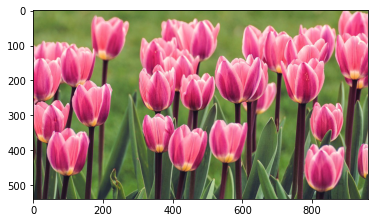

In [96]:
plt.imshow(img)

In [94]:
# Convertendo imagem
img_tensor = data_transform(img).float()

img_tensor = Variable(img_tensor)

img_tensor = img_tensor.unsqueeze(0)

img_tensor = img_tensor.cuda()

print(f'Imagem original: {np.shape(img)}')
print(f'Imagem como tensor: {img_tensor.shape}')

Imagem original: (540, 960, 3)
Imagem como tensor: torch.Size([1, 3, 224, 224])


In [78]:
# Passar a imagem pela rede e verificar a predição
output = model(imgimg_tensor)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)

In [79]:
# Resultado
preds_tensor

tensor([4], device='cuda:0')

In [80]:
# transformar o resultdo em array
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

print(preds)

4


In [82]:
print(f'Imagem classificada como: {classes[preds]}')

Imagem classificada como: tulips
